In [11]:
import math
import numpy as np
from numpy.random import default_rng

import scipy
from scipy.stats import qmc
from smt.sampling_methods import LHS

from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import gpytorch
from sklearn.decomposition import PCA

import time
import os
os.makedirs("fig/0/", exist_ok=True)
os.makedirs("data/0/", exist_ok=True)

%matplotlib inline 
font = {'size'   : 30}
matplotlib.rc('font', **font)
cbformat = matplotlib.ticker.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2))
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.set_default_dtype(torch.float)
torch.set_default_device(device)
torch.set_printoptions(precision=10)

In [12]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[6,],
                 activation=nn.LogSigmoid, activation_kwargs=None):
        super().__init__()
        if activation_kwargs is None:
            activation_kwargs = {}
        act = lambda: activation(**activation_kwargs)

        # ----- Encoder -----
        encoder_layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            encoder_layers.append(nn.Linear(prev_dim, h))
            encoder_layers.append(nn.LayerNorm(h))
            encoder_layers.append(act())
            prev_dim = h
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))  # Final layer to latent
        encoder_layers.append(nn.BatchNorm1d(latent_dim))
        encoder_layers.append(act())
        self.encoder_net = nn.Sequential(*encoder_layers)

        # ----- Decoder -----
        decoder_layers = []
        prev_dim = latent_dim
        for h in reversed(hidden_dims):
            decoder_layers.append(nn.Linear(prev_dim, h))
            decoder_layers.append(act())
            prev_dim = h
        decoder_layers.append(nn.Linear(prev_dim, input_dim))  # Final output
        self.decoder_net = nn.Sequential(*decoder_layers)

    def encode(self, x):
        return self.encoder_net(x)

    def decode(self, z):
        return self.decoder_net(z)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z

    def ae_loss(self, x, lambda_l2_z=0., lambda_l2_param=0.):
        """
        AE loss with optional latent L2 and parameter L2 regularization
    
        Args:
            x: input tensor
            lambda_l2_z: regularization on latent code z (default 1e-3)
            lambda_l2_param: explicit L2 on model parameters (default 1e-3)
    
        Returns:
            total_loss, recon_loss, latent_l2, param_l2
        """
        x_hat, z = self.forward(x)
        recon_loss = F.mse_loss(x_hat, x, reduction='mean')
    
        # --- Latent code regularization ---
        latent_l2 = torch.mean(z.pow(2)) if lambda_l2_z > 0 else torch.tensor(0., device=x.device)
    
        # --- Explicit parameter regularization ---
        param_l2 = torch.tensor(0., device=x.device)
        if lambda_l2_param > 0:
            for param in self.parameters():
                if param.requires_grad:
                    param_l2 += torch.sum(param.pow(2))
    
        total_loss = recon_loss + lambda_l2_z * latent_l2 + lambda_l2_param * param_l2
        return total_loss, recon_loss, latent_l2, param_l2

In [13]:
class ParametricGP(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.log_lengthscale = nn.Parameter(torch.zeros(latent_dim))  # θ_l
        self.log_eta = nn.Parameter(torch.tensor(-1.0))                # log η
        self._last_tau2_hat = 1.0

    def kernel(self, x1, x2):
        """
        Gaussian RBF kernel with ARD (SE-ARD), scaled by tau².
        """
        lengthscale = torch.exp(self.log_lengthscale)
        x1_ = x1 / lengthscale
        x2_ = x2 / lengthscale
        dist_sq = torch.cdist(x1_, x2_, p=2).pow(2)
        return torch.exp(-0.5 * dist_sq)  # base kernel k(x,x')

    def compute_K_eta(self, x):
        """
        Return K + ηI (without τ²), to be scaled externally.
        """
        K = self.kernel(x, x)
        eta = torch.exp(self.log_eta)
        N = x.size(0)
        return K + eta * torch.eye(N, device=x.device)

    def predict(self, x_train, y_train, x_test):
        """
        GP posterior mean and variance following Eqn (2.2) from your paper.
        """
        K_eta = self.compute_K_eta(x_train)
        k_star = self.kernel(x_train, x_test)
        k_ss_diag = torch.ones(x_test.size(0), device=x_test.device)  # since k(x,x)=1

        L = torch.linalg.cholesky(K_eta + 1e-6 * torch.eye(K_eta.shape[0], device=K_eta.device))
        alpha = torch.cholesky_solve(y_train, L)

        # Estimate τ² from data
        N = y_train.shape[0]
        tau2_hat = ((y_train.T @ alpha) / N).squeeze().detach()
        self._last_tau2_hat = tau2_hat.item()

        mean = k_star.T @ alpha                                 # (M, 1)
        v = torch.cholesky_solve(k_star, L)
        k_star_Kinv_k_star = (k_star.T @ v).diagonal().unsqueeze(-1)
        eta = torch.exp(self.log_eta)

        var = tau2_hat * (1 + eta - k_star_Kinv_k_star)         # (M, 1)
        return mean, var

    def log_marginal_likelihood(self, x_train, y_train):
        """
        Profiled log-likelihood over η, using τ² = yᵀ K⁻¹ y / N
        """
        K_eta = self.compute_K_eta(x_train)
        L = torch.linalg.cholesky(K_eta + 1e-6 * torch.eye(K_eta.shape[0], device=K_eta.device))
        alpha = torch.cholesky_solve(y_train, L)

        N = y_train.shape[0]
        tau2_hat = ((y_train.T @ alpha) / N).squeeze().detach()
        self._last_tau2_hat = tau2_hat.item()

        term1 = y_train.T @ alpha
        term2 = torch.logdet(K_eta)
        return -(term1 + term2).squeeze()
    def log_marginal_likelihood(self, x_train, y_train):
        """
        Log marginal likelihood, with τ² = hat τ²
        """
        N = y_train.shape[0]
        K_eta = self.compute_K_eta(x_train)            # (N, N)
        L = torch.linalg.cholesky(K_eta + 1e-6 * torch.eye(N, device=K_eta.device))
        alpha = torch.cholesky_solve(y_train, L)           # (N, 1)

        tau2_hat = (y_train.T @ alpha) / N                 # scalar
        term1 = N * tau2_hat.log()
        term2 = 2 * L.diag().log().sum()
        # const: term3 = N * math.log(2 * math.pi)

        nll = term1 + term2 # half positive log likelihood
        return -nll.squeeze()

    def get_hyperparams(self):
        return {
            "lengthscale": torch.exp(self.log_lengthscale).detach(),
            "eta": torch.exp(self.log_eta).item(),
            "tau²_hat": self._last_tau2_hat
        }

In [14]:
class JointModel(nn.Module):
    def __init__(self, ae, gp):
        """
        ae: Autoencoder model (with .encode(x): (N, d))
        gp: ParametricGP model (with .predict and .log_marginal_likelihood)
        """
        super().__init__()
        self.ae = ae
        self.gp = gp

    def forward(self, x_train, y_train, x_test):
        """
        Run AE + GP prediction pipeline

        Args:
            x_train: (N, D) input data
            y_train: (N, 1) target values
            x_test:  (M, D) test input data

        Returns:
            y_pred: mean predictions (M, 1)
            y_var:  predictive variances (M, 1)
        """
        z_train = self.ae.encode(x_train)  # (N, d)
        z_test = self.ae.encode(x_test)    # (M, d)
        return self.gp.predict(z_train, y_train, z_test)

    def loss(self, x, y):
        """
        Loss function: AE reconstruction + GP negative log marginal likelihood

        Args:
            x: (N, D)
            y: (N, 1)

        Returns:
            total_loss:  scalar
            ae_loss:     scalar
            gp_nll:      scalar
        """
        # Autoencoder loss
        ae_total, ae_recon, _, _ = self.ae.ae_loss(x)

        # GP negative log marginal likelihood
        z = self.ae.encode(x)
        gp_nll = -self.gp.log_marginal_likelihood(z, y)  # (maximize log-likelihood = minimize -ll)

        # Combined loss
        total_loss = ae_total + gp_nll
        #return total_loss, ae_total, gp_nll
        return total_loss, ae_total, gp_nll

In [15]:
def generate_dataset_for_al_gp(
    N_train=10,
    N_test=500,
    N_ref=100,
    N_cand=100,
    bounds=[0., 10.0],
    degree=45,
    noise_scale=0.1,
    device="cpu",
    seed=None
):
    """
    Generate active learning sets using rotated 2D Gaussian mixture function.

    Returns:
        x_train, y_train
        x_test, y_test
        x_ref, y_ref
        x_cand, y_cand
    """
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)

    def f(x_np):  # expects numpy array, returns numpy array
        phi = degree * np.pi / 180
        rot = np.array([
            [np.cos(phi), -np.sin(phi)],
            [np.sin(phi),  np.cos(phi)]
        ])
        x_rot = x_np @ rot.T
        y1 = scipy.stats.norm(3, 0.5).logpdf(x_rot[:, [1]])
        y2 = scipy.stats.norm(-3, 0.5).logpdf(x_rot[:, [1]])
        y = 1 - np.exp(y1) - np.exp(y2) + x_rot[:, [0]] / 100
        return y.astype(np.float32)

    def lhs_sample(N, bounds, d=2):
        bounds_np = np.array([bounds] * d)
        lhs = LHS(xlimits=bounds_np, criterion="maximin")
        return lhs(N)

    # Training set
    x_train_np = lhs_sample(N_train, bounds)
    y_train_np = f(x_train_np) + np.random.randn(N_train, 1) * noise_scale

    # Test set
    x_test_np = lhs_sample(N_test, bounds)
    y_test_np = f(x_test_np) + np.random.randn(N_test, 1) * noise_scale

    # Reference set
    x_ref_np = lhs_sample(N_ref, bounds)
    y_ref_np = f(x_ref_np)

    # Candidate set
    x_cand_np = lhs_sample(N_cand, bounds)
    y_cand_np = f(x_cand_np) + np.random.randn(N_cand, 1) * noise_scale

    # Convert to torch
    def to_tensor(x, y):
        return (
            torch.tensor(x, dtype=torch.float, device=device),
            torch.tensor(y, dtype=torch.float, device=device)
        )

    return (
        *to_tensor(x_train_np, y_train_np),
        *to_tensor(x_test_np, y_test_np),
        *to_tensor(x_ref_np, y_ref_np),
        *to_tensor(x_cand_np, y_cand_np)
    )

In [16]:
def train_joint(
    model, x_train, y_train,
    max_outer_iter=2000,
    max_inner_iter=10,
    tol_loss_change_pct=1e-4,
    verbose=False,
):
    """
    Train a JointModel using L-BFGS with outer loop and early stopping.

    Args:
        model: JointModel instance
        x_train: (N, D)
        y_train: (N, 1)
        max_outer_iter: number of outer optimization steps
        max_inner_iter: L-BFGS inner max_iter
        tol_loss_change_pct: relative loss change to early stop
        verbose: whether to print log

    Returns:
        loss_history: list of total loss per outer iteration
    """
    loss_history = []

    optimizer = torch.optim.LBFGS(
        model.parameters(),
        lr=0.01,
        history_size=50,
        max_iter=max_inner_iter,
        line_search_fn="strong_wolfe"
    )

    for outer_epoch in range(max_outer_iter):
        def closure():
            optimizer.zero_grad()
            total_loss, ae_loss, gp_nll = model.loss(x_train, y_train)
            if torch.isnan(total_loss) or torch.isinf(total_loss):
                print("  total_loss is NaN/Inf")
            if torch.isnan(ae_loss) or torch.isinf(ae_loss):
                print("  ae_loss is NaN/Inf")
            if torch.isnan(gp_nll) or torch.isinf(gp_nll):
                print("  gp_nll is NaN/Inf")
            total_loss.backward()
            if verbose:
                print(f"[Epoch {outer_epoch:03d}] Total: {total_loss.item():.5f} | AE: {ae_loss.item():.5f} | GP-NLL: {gp_nll.item():.5f}")
            return total_loss

        optimizer.step(closure)

        # Compute current loss for stopping check
        with torch.no_grad():
            current_loss, _, _ = model.loss(x_train, y_train)
            loss_history.append(current_loss.item())

        # Early stopping check
        if len(loss_history) >= 2:
            numer = abs(loss_history[-1] - loss_history[-2])
            denom = abs(loss_history[-1] - loss_history[0]) + 1e-6
            rel_change = numer / denom
            if rel_change < tol_loss_change_pct:
                if verbose:
                    print(f"[Stopping] Relative loss change {rel_change:.2e} < tol {tol_loss_change_pct}")
                break
    return loss_history

In [17]:
def alc_acquisition(model, x_train, y_train, x_cand, x_ref, k_variance=10):
    """
    Two-stage ALC acquisition:
    1. From all candidates, pick top-k_variance with highest posterior variance.
    2. Among these, compute exact ALC (Cohn style) and select best one.
    """
    model.gp.eval()
    model.ae.eval()

    N, Nc, Nr = x_train.shape[0], x_cand.shape[0], x_ref.shape[0]
    device = x_train.device

    with torch.no_grad():
        # Encode inputs
        z_train = model.ae.encode(x_train)
        z_cand = model.ae.encode(x_cand)
        z_ref = model.ae.encode(x_ref)

        # GP kernel and posterior variance
        K = model.gp.compute_K_eta(z_train)  # (N, N)
        L = torch.linalg.cholesky(K + 1e-6 * torch.eye(N, device=device))
        K_s = model.gp.kernel(z_train, z_cand)  # (N, Nc)
        v = torch.cholesky_solve(K_s, L)
        var_cand = model.gp.compute_K_eta(z_cand).diagonal(dim1=0, dim2=1) - (K_s * v).sum(dim=0)
        #print(var_cand)
        #mean_cand,var_cand = model.gp.predict(z_train, y_train, z_cand)
        #print(var_cand)

        topk_var_idx = torch.topk(var_cand, k=min(k_variance, Nc)).indices

        # Compute tau² (MLE of variance)
        alpha = torch.cholesky_solve(y_train, L)
        tau2_hat = (y_train.T @ alpha / N).squeeze()

        # Base posterior covariance at z_ref
        K_s_ref = model.gp.kernel(z_train, z_ref)
        K_ss_ref = model.gp.kernel(z_ref,z_ref)
        v_ref = torch.cholesky_solve(K_s_ref, L)
        cov_orig = K_ss_ref - K_s_ref.T @ v_ref
        trace_orig = cov_orig.diag().sum()

        # Evaluate ALC among top candidates
        best_score = -float('inf')
        best_idx = -1

        for idx in topk_var_idx:
            x_aug = torch.vstack([x_train, x_cand[idx:idx+1]])
            z_aug = model.ae.encode(x_aug)

            K_aug = model.gp.compute_K_eta(z_aug)
            L_aug = torch.linalg.cholesky(K_aug + 1e-6 * torch.eye(K_aug.size(0), device=device))

            K_s_aug = model.gp.kernel(z_aug, z_ref)
            K_ss_aug = model.gp.kernel(z_ref,z_ref)
            v_aug = torch.cholesky_solve(K_s_aug, L_aug)
            cov_new = K_ss_aug - K_s_aug.T @ v_aug

            trace_new = cov_new.diag().sum()
            alc_score = tau2_hat * (trace_orig - trace_new)

            if alc_score > best_score:
                best_score = alc_score
                best_idx = idx.item()

    return best_idx, best_score

In [18]:
def run_active_learning(
    model, x_train_init, y_train_init,
    x_cand, y_cand,
    x_ref, x_test, y_test,
    T=100,
    save_plot_path=None,
    randomAC = False,
    topk=100,
    epsilon=0.02,     # RMSE 阈值
    delta=1e-4,       # 最小改进
    patience=3        # 连续容忍次数
):
    """
    Active learning loop with early stopping based on RMSE threshold and small improvement tolerance.
    """
    x_train = x_train_init.clone()
    y_train = y_train_init.clone()

    rmse_list = []
    T = min(T, len(y_cand))
    slow_count = 0

    for t in range(T):
        print(f"\n--- Round {t} ---")

        # Retrain model
        model.train()
        train_joint(model, x_train, y_train, max_outer_iter=5000, verbose=False)
        print(model.gp.get_hyperparams())

        # Evaluate on test
        model.eval()
        with torch.no_grad():
            z_train = model.ae.encode(x_train)
            z_test = model.ae.encode(x_test)
            y_pred, y_var = model.gp.predict(z_train, y_train, z_test)
            rmse = torch.sqrt(torch.mean((y_pred - y_test) ** 2)).item()
            print(f"Test RMSE: {rmse:.4f}")
            rmse_list.append(rmse)
        if randomAC:
            best_idx = np.random.choice(len(y_cand), size=1, replace=False)
        else:
            # ALC acquisition from x_cand
            best_idx, _ = alc_acquisition(model, x_train, y_train, x_cand, x_ref, k_variance=topk)
        if isinstance(best_idx, int):
            best_idx = [best_idx]

        # Add selected point to training set
        x_new = x_cand[best_idx]
        y_new = y_cand[best_idx]
        x_train = torch.cat([x_train, x_new], dim=0)
        y_train = torch.cat([y_train, y_new], dim=0)

        # Remove selected from candidate pool
        mask = torch.ones(len(x_cand), dtype=torch.bool, device=x_cand.device)
        mask[best_idx] = False
        x_cand = x_cand[mask]
        y_cand = y_cand[mask]
    return {
        "rmse": np.array(rmse_list),
        "final_x_train": x_train,
        "final_y_train": y_train,
        "x_test": x_test
    }

In [19]:
# === 2. 生成数据 ===
x_train, y_train, x_test, y_test, x_ref, y_ref, x_cand, y_cand = generate_dataset_for_al_gp(
    N_train=50,
    N_test=500,
    N_ref=2000,
    N_cand=2000,
    noise_scale=0.,
    device=device,
    seed=None
)
np.save('data/0/ALAEmGP-2dSynthetic-xtrainInitial.npy',x_train.cpu().numpy())
np.save('data/0/ALAEmGP-2dSynthetic-ytrainInitial.npy',y_train.cpu().numpy())

# === 3. 初始化模型 ===
ae = Autoencoder(input_dim=2, latent_dim=3,hidden_dims=[10,]).to(device)
gp = ParametricGP(latent_dim=3).to(device)
model = JointModel(ae, gp).to(device)

import copy

ae_copy = Autoencoder(input_dim=2, latent_dim=3, hidden_dims=[10,]).to(device)
gp_copy = ParametricGP(latent_dim=3).to(device)
model_copy = JointModel(ae_copy, gp_copy).to(device)

model_copy.load_state_dict(copy.deepcopy(model.state_dict()))

# === 4. 运行主循环 ===
result = run_active_learning(
    model=model,
    x_train_init=x_train,
    y_train_init=y_train,
    x_cand=x_cand,
    y_cand=y_cand,
    x_ref=x_ref,
    x_test=x_test,
    y_test=y_test,
    T=50,
    save_plot_path="fig/0/ALAEmGP-2dSynthetic",
    randomAC=False
)

np.save('data/0/ALAEmGP-2dSynthetic-xtrainFinal.npy',result['final_x_train'].cpu().numpy())
np.save('data/0/ALAEmGP-2dSynthetic-ytrainFinal.npy',result['final_y_train'].cpu().numpy())
np.save('data/0/ALAEmGP-2dSynthetic-xtest.npy',result['x_test'].cpu().numpy())
np.save('data/0/ALAEmGP-2dSynthetic-testrmse.npy',result['rmse'])


--- Round 0 ---
{'lengthscale': tensor([3.0841498375, 4.7950801849, 7.2365627289], device='cuda:0'), 'eta': 2.788028541544918e-05, 'tau²_hat': 1.0}
Test RMSE: 0.1617

--- Round 1 ---
{'lengthscale': tensor([3.0829293728, 4.7951383591, 7.2365627289], device='cuda:0'), 'eta': 2.7878742912434973e-05, 'tau²_hat': 2.1814184188842773}
Test RMSE: 0.1641

--- Round 2 ---
{'lengthscale': tensor([3.0593955517, 4.7963228226, 7.2365550995], device='cuda:0'), 'eta': 2.7843696443596855e-05, 'tau²_hat': 6.584414482116699}
Test RMSE: 0.1607

--- Round 3 ---
{'lengthscale': tensor([3.0593316555, 4.7963061333, 7.2365550995], device='cuda:0'), 'eta': 2.7843643692904152e-05, 'tau²_hat': 2.637317419052124}
Test RMSE: 0.1606

--- Round 4 ---
{'lengthscale': tensor([3.0610697269, 4.7928547859, 7.2365550995], device='cuda:0'), 'eta': 2.7868827601196244e-05, 'tau²_hat': 2.9135212898254395}
Test RMSE: 0.1535

--- Round 5 ---
{'lengthscale': tensor([3.0204114914, 4.7976751328, 7.2365565300], device='cuda:0'), '

final result 0.0110620791092515
first result 0.16170823574066162


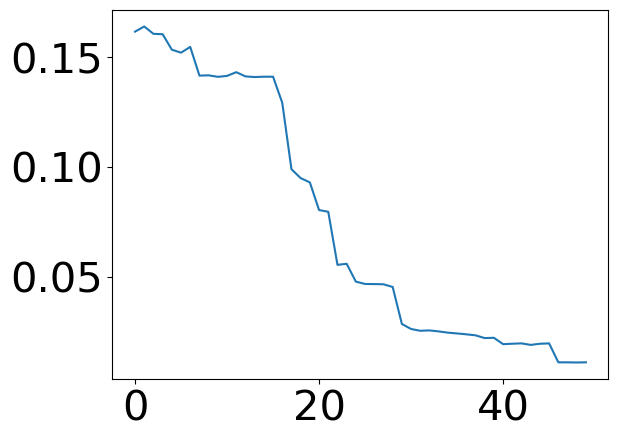

In [20]:
print('final result', result['rmse'][-1])
print('first result', result['rmse'][0])
plt.plot(result['rmse']);

In [21]:
result_random = run_active_learning(
    model=model_copy,
    x_train_init=x_train,
    y_train_init=y_train,
    x_cand=x_cand,
    y_cand=y_cand,
    x_ref=x_ref,
    x_test=x_test,
    y_test=y_test,
    T=50,
    save_plot_path="fig/0/rALAEmGP-2dSynthetic",
    randomAC=True
)
np.save('data/0/rALAEmGP-2dSynthetic-xtrainFinal.npy',result_random['final_x_train'].cpu().numpy())
np.save('data/0/rALAEmGP-2dSynthetic-ytrainFinal.npy',result_random['final_y_train'].cpu().numpy())
np.save('data/0/rALAEmGP-2dSynthetic-testrmse.npy',result_random['rmse'])


--- Round 0 ---
{'lengthscale': tensor([3.0841498375, 4.7950801849, 7.2365627289], device='cuda:0'), 'eta': 2.788028541544918e-05, 'tau²_hat': 1.0}
Test RMSE: 0.1617

--- Round 1 ---
{'lengthscale': tensor([3.0840177536, 4.7949700356, 7.2365627289], device='cuda:0'), 'eta': 2.787999255815521e-05, 'tau²_hat': 2.1814184188842773}
Test RMSE: 0.1616

--- Round 2 ---
{'lengthscale': tensor([3.0835390091, 4.7947287560, 7.2365627289], device='cuda:0'), 'eta': 2.7879194021807052e-05, 'tau²_hat': 2.1296627521514893}
Test RMSE: 0.1615

--- Round 3 ---
{'lengthscale': tensor([3.0830612183, 4.7945270538, 7.2365627289], device='cuda:0'), 'eta': 2.7878502805833705e-05, 'tau²_hat': 2.11240816116333}
Test RMSE: 0.1617

--- Round 4 ---
{'lengthscale': tensor([3.0828173161, 4.7944130898, 7.2365627289], device='cuda:0'), 'eta': 2.787813173199538e-05, 'tau²_hat': 2.1818766593933105}
Test RMSE: 0.1617

--- Round 5 ---
{'lengthscale': tensor([3.0804984570, 4.7931027412, 7.2365646362], device='cuda:0'), 'et

final result 0.16128994524478912
first result 0.16170823574066162


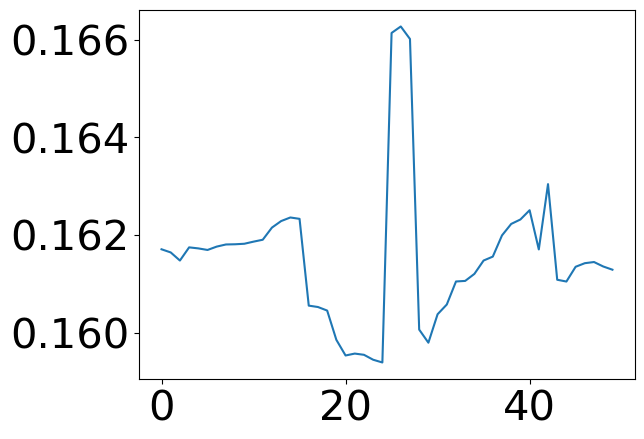

In [22]:
print('final result', result_random['rmse'][-1])
print('first result', result_random['rmse'][0])
plt.plot(result_random['rmse']);